## Synchronised Chaos

### Implementing the transmitter and receiver

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Parameters of a chaotic Lorenz system
r, s, b = (28, 10, 8/3)

# Setting the time step and total simulation time
dt = 0.001
steps = 120000

# Initial conditions for transmitter
state_transmitter = np.empty((steps + 1, 3))  # Need one more for the initial values
state_transmitter[0] = (0, 1.0, 1.05) 

# Initial conditions for receiver
state_receiver = np.empty((steps + 1, 3)) 
state_receiver[0] = (0.1, 3.0, 0.05)  # If the system synchronises, any initial values work

t = np.linspace(0, steps*dt, steps+1)   # time array

# Message signal sample
a = 1.0   # Modulate amplitude, if needed
m = np.sin(60*t) + np.cos(40*t) + np.sin(20*np.pi*t) + np.cos(30*t)

# Defining the transmitter Lorenz system
def transmitter(initial_transmitter):
    x, y, z = initial_transmitter   # Initial conditions unpacked as a tuple
    dx_dt = s*(y-x)
    dy_dt = r*x - y - x*z
    dz_dt = x*y - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# Defining the receiver Lorenz system
def receiver(initial_receiver, input_signal):
    x, y, z = initial_receiver 
    dx_dt = s*(y-x) 
    dy_dt = r*input_signal - y - input_signal*z
    dz_dt = input_signal*y - b*z
    return np.array([dx_dt, dy_dt, dz_dt])

# 4th Order Runge Kutta method (RK4)
def RK4(dt, function, state, *args):
    k1 = function(state, *args)
    k2 = function(state + (dt*k1)/2, *args)
    k3 = function(state + (dt*k2)/2, *args)
    k4 = function(state + dt*k3, *args)
    return state + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

# Use RK4 to numerically solve for transmitter system
for i in range(steps):
    state_transmitter[i + 1] = RK4(dt, transmitter, state_transmitter[i])

# Generating the mask to encrypt the signal
x_values = state_transmitter[:, 0]  
masked_values = x_values + m

# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_values[i])

# Regenerating the mask to decrypt the signal
xr_values = state_receiver[:, 0]
decrypt = masked_values - xr_values
error = np.abs(xr_values - x_values) # Error should decrease exponentially with time

'''
If we pass x_values[i] instead of masked_values[i], the 2 systems synchronises.
We would regenerate the mask exactly after some transient state.
However, the point of the recevier is to accept s(t) as input
There is no proof that the 2 systems synchronise (indeed they don't)
So far my observation is that sine waves of higher frequency works better
Somehow amplitude doesn't really matter, even though they should?
'''

"\nIf we pass x_values[i] instead of masked_values[i], the 2 systems synchronises.\nWe would regenerate the mask exactly after some transient state.\nHowever, the point of the recevier is to accept s(t) as input\nThere is no proof that the 2 systems synchronise (indeed they don't)\nSo far my observation is that sine waves of higher frequency works better\nSomehow amplitude doesn't really matter, even though they should?\n"

### Processing audio files

0.025958007966865548


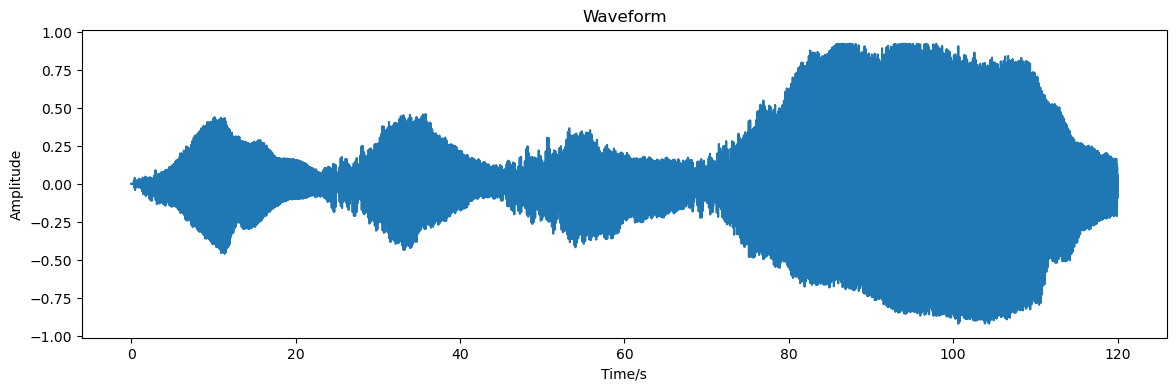

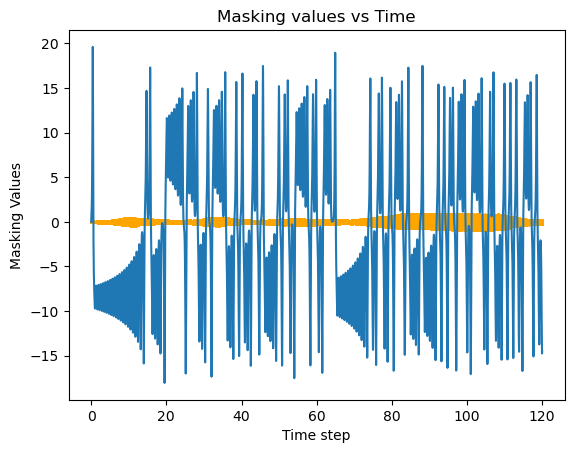

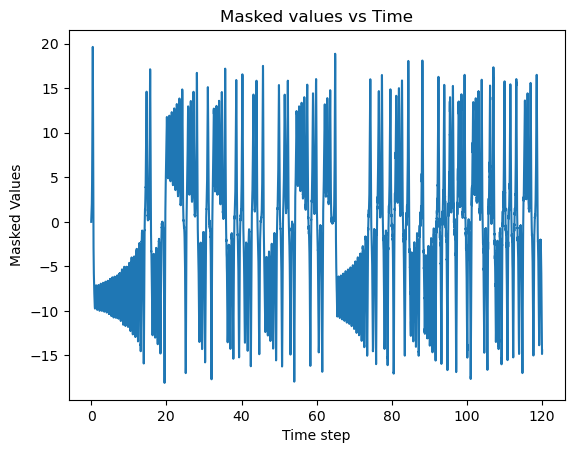

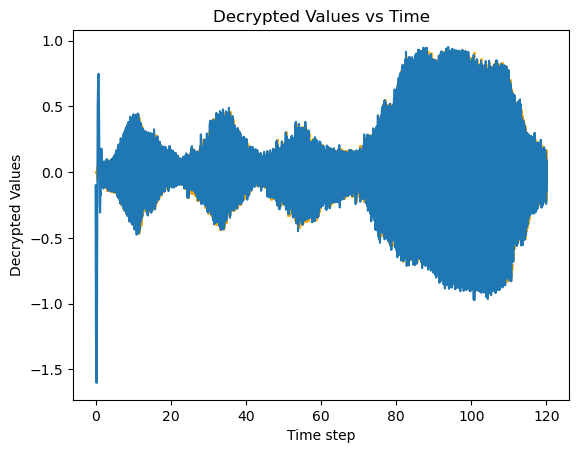

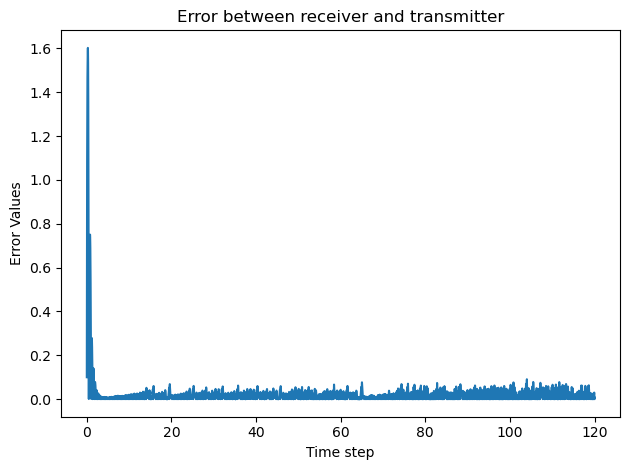

In [32]:
# Processing a WAV file

from scipy.io.wavfile import read

# Read a WAV file
sample_rate, data = read("gameover.wav")

simulation_time = steps * dt
amplitude = 1/32767   # To normalise the amplitude
time = np.arange(len(data)) / sample_rate  # Time axis in seconds
time_scale = simulation_time / time[steps+1]
times = time_scale * time[:steps+1]
sound_waves = amplitude*data[:steps+1,0]   # Use only one of the stereo waveforms

plt.figure(figsize=(14, 4))
plt.plot(times, sound_waves)
plt.xlabel("Time/s")
plt.ylabel("Amplitude")
plt.title("Waveform")

masked_sound = x_values + sound_waves

# Use RK4 to numerically solve for receiver system
for i in range(steps):
    state_receiver[i + 1] = RK4(dt, receiver, state_receiver[i], masked_sound[i])

# Regenerating the mask to decrypt the signal
xs_values = state_receiver[:, 0]
decrypt_s = masked_sound - xs_values
error = np.abs(xs_values - x_values) # Error should decrease exponentially with time

# Calculate mean error in decryption
decrypt_error = np.mean(np.abs(decrypt_s - sound_waves))
print(decrypt_error)

# Plotting the chaotic mask and message signal
ax = plt.figure().add_subplot()
ax.plot(t, x_values)
ax.set_xlabel("Time step")
ax.set_ylabel("Masking Values")
ax.set_title('Masking values vs Time')
plt.scatter(times, sound_waves, c="orange", s=1)

# Plotting the masked signal
ax = plt.figure().add_subplot()
ax.plot(t, masked_sound)
ax.set_xlabel("Time step")
ax.set_ylabel("Masked Values")
ax.set_title('Masked values vs Time')

# Plotting the retrieved signal
ax = plt.figure().add_subplot()
ax.plot(t, decrypt_s)
ax.set_xlabel("Time step")
ax.set_ylabel("Decrypted Values")
ax.set_title('Decrypted Values vs Time')
plt.scatter(times, sound_waves, c="orange", s=1)

# Plotting the error
ax = plt.figure().add_subplot()
ax.plot(t, error)
ax.set_xlabel("Time step")
ax.set_ylabel("Error Values")
ax.set_title('Error between receiver and transmitter')

plt.tight_layout()
plt.show()

In [26]:
from scipy.io.wavfile import write

y1_int16 = (masked_sound * 32767).astype(np.int16)
y2_int16 = (decrypt_s * 32767).astype(np.int16)

write("encrypted.wav", sample_rate, y1_int16)
write("decrypted.wav", sample_rate, y2_int16)